In [1]:
# This code cleans Kaggle SQLi dataset and splits to test-train files.
# The code is mostly taken from two other notebooks:
# See https://www.kaggle.com/datasets/syedsaqlainhussain/sql-injection-dataset/code
# eda-sql-injection-dataset notebook at Kaggle
# sql-inject-using-linear-models-and-cnn  notebook at Kaggle

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib


In [2]:
from pathlib import Path
main_folder = Path(r"C:\Users\3057550\OneDrive - Queen's University Belfast\ECIT\Research\AI_Cybersecurity\Code_Projects\github_rafi_SQLi\rafi-sqli-detection\utils\sample_datasets")

### Reading and displaying the dataset

In [3]:
df = pd.read_csv(main_folder / 'SQLiV3.csv', encoding='utf-8') # Read the dataset.
df.head(10)

,Sentence,Label,Unnamed: 2,Unnamed: 3
0,""" or pg_sleep ( __TIME__ ) --",1,NaN,NaN
1,create user name identified by pass123 tempora...,NaN,1,NaN
2,AND 1 = utl_inaddr.get_host_address ( ...,1,NaN,NaN
3,select * from users where id = '1' or @ @1 ...,1,NaN,NaN
4,"select * from users where id = 1 or 1#"" ( ...",1,NaN,NaN
5,select name from syscolumns where id = ...,1,NaN,NaN
6,select * from users where id = 1 +$+ or 1 =...,1,NaN,NaN
7,"1; ( load_file ( char ( 47,101,116,99,47...",1,NaN,NaN
8,select * from users where id = '1' or ||/1 ...,1,NaN,NaN
9,select * from users where id = '1' or \.<\ ...,1,NaN,NaN


### Removing unused columns

In [4]:
del df['Unnamed: 2']

del df['Unnamed: 3']

In [5]:
df.shape

(30919, 2)

In [6]:
df.head()

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,NaN
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [7]:
print("----------------------------------------------------")
df.info()
print("----------------------------------------------------")

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  30904 non-null  object
 1   Label     30664 non-null  object
dtypes: object(2)
memory usage: 483.2+ KB
----------------------------------------------------


In [8]:
df['Label'].describe()

count     30664
unique       42
top           0
freq      19268
Name: Label, dtype: object

#### Process NaN values

In [9]:
df['Label'].isna().sum() # Count NaN label values.

255

In [10]:
df = df.dropna() # Remove Nan values.

### Fixing the target label

In [11]:
# Get unique values existing in the label column.

unique_label = pd.unique(df['Label'])

print('\n'.join(l for l in unique_label))

1
SELECT *
 --
 desc users
 OR
waitfor delay '0:0:__TIME__'--
 drop table temp --
0
 grant resource to name
 EXEC SelectAllCustomers
 /*Select all the columns of all the records in the Customers table:*/
*/
 CREATE VIEW [Products Above Average Price] AS
 CREATE OR REPLACE VIEW view_name AS
 DROP TABLE Suppliers
 CREATE PROCEDURE SelectAllCustomers AS
  EXEC SelectAllCustomers
 DELETE FROM Customers  WHERE CustomerName = 'Alfreds Futterkiste'
 CREATE OR REPLACE VIEW [Brazil Customers] AS
  SELECT * FROM CustomersLIMIT 3
SELECT * FROM Customers
 SELECT TOP 50 PERCENT * FROM Customers
 SELECT * FROM CustomersFETCH FIRST 50 PERCENT ROWS ONLY
SELECT TOP 3 * FROM Customers
 SELECT * FROM Customers
SELECT SUM ( Quantity ) 
 SELECT column_name ( s ) 
 SELECT City FROM Customers



#### Above, we can see that the label contains more than simply 0s and 1s. We need to fix the errors it includes.

In [12]:
df = df.drop(df[(df['Label'] != '0') & (df['Label'] != '1')].index) # Dropping the label values, that are different from 0 or 1.

In [13]:
df['Label'] = df['Label'].astype('int') # Convert the label type to integer.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30609 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  30609 non-null  object
 1   Label     30609 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 597.8+ KB


In [15]:
df[df['Label'] == 1].count() # Count how much label are 1.

Sentence    11341
Label       11341
dtype: int64

In [16]:
df[df['Label'] == 0].count() # Count how much label are 0.

Sentence    19268
Label       19268
dtype: int64

### Distribution of the label

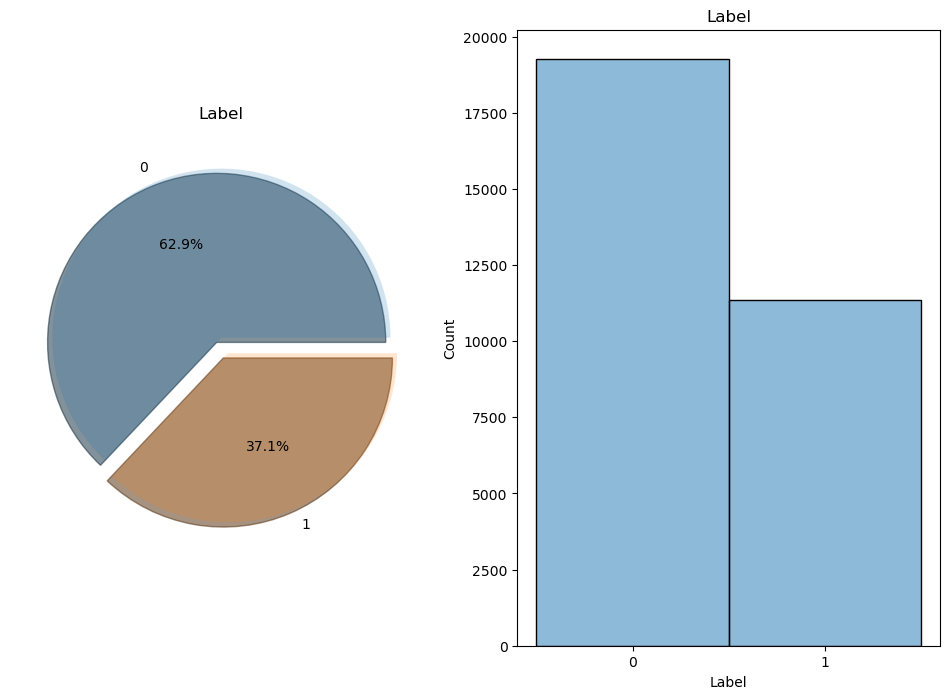

In [24]:
f,ax=plt.subplots(1,2,figsize=(12,8))
df['Label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True, wedgeprops={'alpha':0.2})


ax[0].set_title('Label')
ax[0].set_ylabel('')

sns.histplot(data=df, x='Label', ax=ax[1], alpha=0.5, discrete=True)
ax[1].set_title('Label')
ax[1].set_xticks(ticks=[0,1])
plt.show()

In [25]:
df.head()

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
5,select name from syscolumns where id = ...,1


### How many comments symbols are in the payloads ?

In [26]:
comment_values = df[df.Sentence.str.contains('#|--|//')]

In [27]:
comment_values.count()[0] # How many comments symbols are in the payloads.

5905

### The tables in the payloads

In [28]:
from_values = df[df.Sentence.str.contains('from')]

In [29]:
# Print the existing tables in the payload.
l = list(from_values.Sentence)

tables = []
for i in l:
    x = i[i.index('from')+5:].split(' ')
    if x[0] not in tables and len(x[0]) > 1:
        tables.append(x[0])
print(tables)

['users', 'syscolumns', 'sysobjects', 'information_schema.tables--', 'temp', 'where', 'wapiti', 'generate_series', 'information_schema.character_sets', 'dual', 'pg_sleep', 'all_users', 'sysibm.systables', 'rdb$database', 'sysusers', 'mysql.db', 'domain.domains', 'rdb$fields', 'master..sysdatabases', 'information_schema.system_users', 'dual--', 'dual#', 'WHERE', 'ROM', 'JOIN']


### Top used wods in payloads

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\3057550\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\3057550\AppData\Local\Temp\ipykernel_17100\2642366206.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  payloads = df.Sentence.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')


All frequencies, including STOPWORDS:
        Frequency
Word             
)           50682
(           45635
select      22494
=           17735
,           17640
from        16154
'           15785
1           10166
*            9839
where        8267


C:\Users\3057550\AppData\Local\Temp\ipykernel_17100\2642366206.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn-white')


<AxesSubplot: xlabel='Word'>

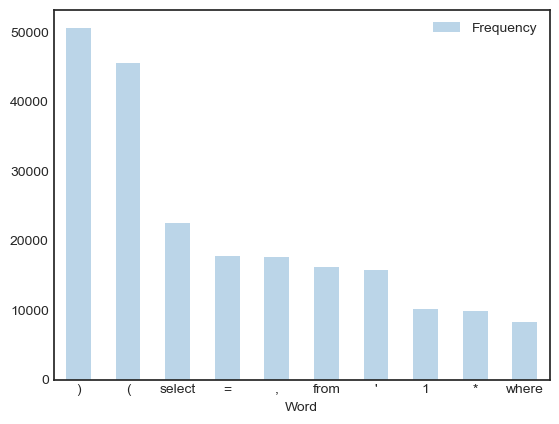

In [30]:
import nltk
nltk.download('punkt')
top_N = 10


payloads = df.Sentence.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(payloads)
word_dist = nltk.FreqDist(words)


print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
print(rslt)
print('=' * 60)

matplotlib.style.use('seaborn-white')

rslt.plot.bar(rot=0, alpha=0.3)

# Save the cleaned dataset

In [31]:
df.tail()

,Sentence,Label
30914,DELETE FROM door WHERE grow = 'small',0
30915,DELETE FROM tomorrow,0
30916,SELECT wide ( s ) FROM west,0
30917,SELECT * FROM ( SELECT slide FROM breath ),0
30918,SELECT TOP 3 * FROM race,0


In [32]:
df.to_csv(main_folder / 'SQLiV3_cleaned.csv', sep=',', encoding='utf-8') # Write the cleaned dataset.

## Split to test train

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
df_train, df_test = train_test_split(df, test_size = 0.2)
print(df_train.shape, df_test.shape)
print("Dataset Input:", "\n", df_train.head(5))
print("Dataset Label:", "\n", df_test.head(5))

(24487, 2) (6122, 2)
Dataset Input: 
                                                 Sentence  Label
28493  SELECT AVG ( gradually ) FROM load SELECT SUM ...      0
13795                                        guardia, la      0
22665       SELECT * FROM  ( SELECT highway FROM walk )       0
7234   1'+  (  select 'wyxu' where 2555  =  2555 unio...      1
27329  SELECT AVG ( war ) FROM layers SELECT SUM ( me...      0
Dataset Label: 
                                                 Sentence  Label
541     select * from users where id  =  1 or "._" or...      1
29933     SELECT flame, shaking, gulfFROM buried WHER...      0
4404   1%"   )    )     )   or updatexml  (  1808,con...      1
18933                           travesia palacio 61, 1?d      0
28192  SELECT * FROM explore WHERE with = 'affect' LI...      0


In [35]:
df_train.to_csv(main_folder / 'SQLiV3_train.tsv', index=False, header=['Payload', 'Attacker'], sep='\t', encoding='utf-8') # Write the train dataset.
df_test.to_csv(main_folder / 'SQLiV3_test.tsv', index=False, header=['Payload', 'Attacker'], sep='\t', encoding='utf-8') # Write the test dataset.